In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

2553    this was the most diverse audience for a superhero film ever .
1406                                  he was also influenced by films:
581                            the film was released on july 14, 2000.
4022                  it is peter jackson's lowest rated film to date.
2825           the film won four nandi awards and two filmfare awards.
Name: sentence, dtype: object

In [4]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [5]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [7]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [8]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:29<00:00, 48.42it/s]


In [9]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [10]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [11]:
get_relation("John completed the task")

'completed'

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:20<00:00, 53.62it/s]


In [13]:
pd.Series(relations).value_counts()[:50]

is               372
was              302
released on       88
are               74
include           72
were              67
released          42
's                39
composed by       35
have              31
became            31
has               30
become            28
released in       27
included          25
called            21
had               21
made              20
considered        20
been              19
produced          19
used              18
scheduled         17
be                16
written by        15
received          15
produced by       14
hired             14
stars             14
wrote             14
went              13
introduced in     13
wanted            12
directed by       12
won               11
began             11
began in          11
gave              10
set               10
sold              10
features          10
said               9
produced in        9
reported           9
shot in            9
used in            9
opened             9
includes     

In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [15]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

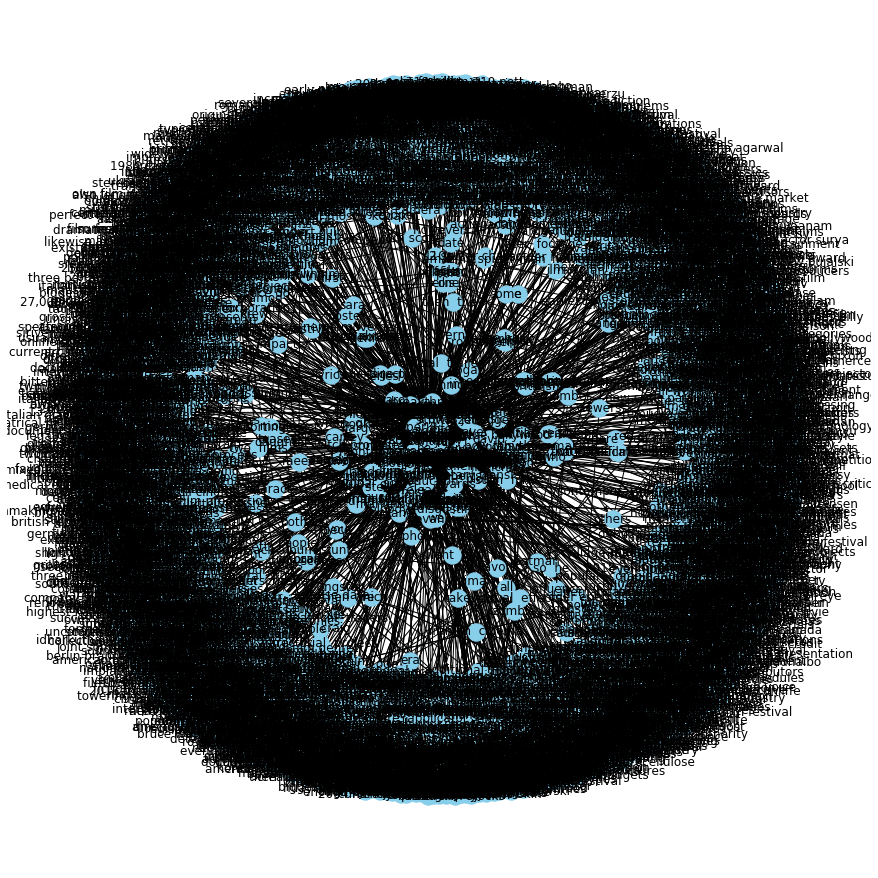

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

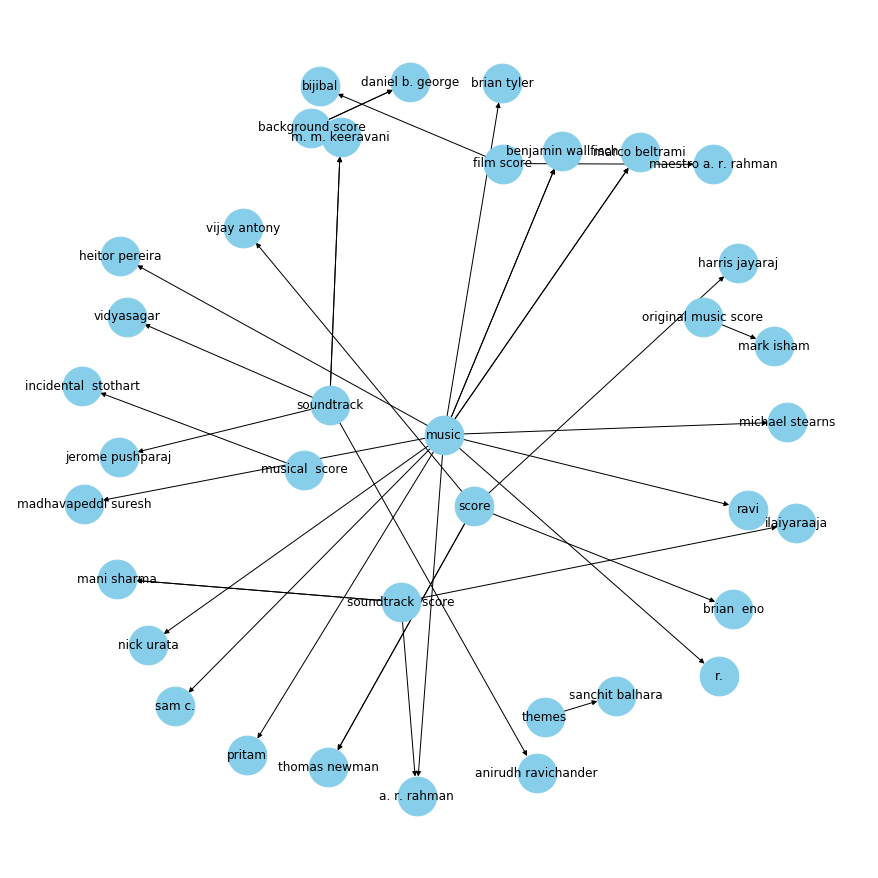

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

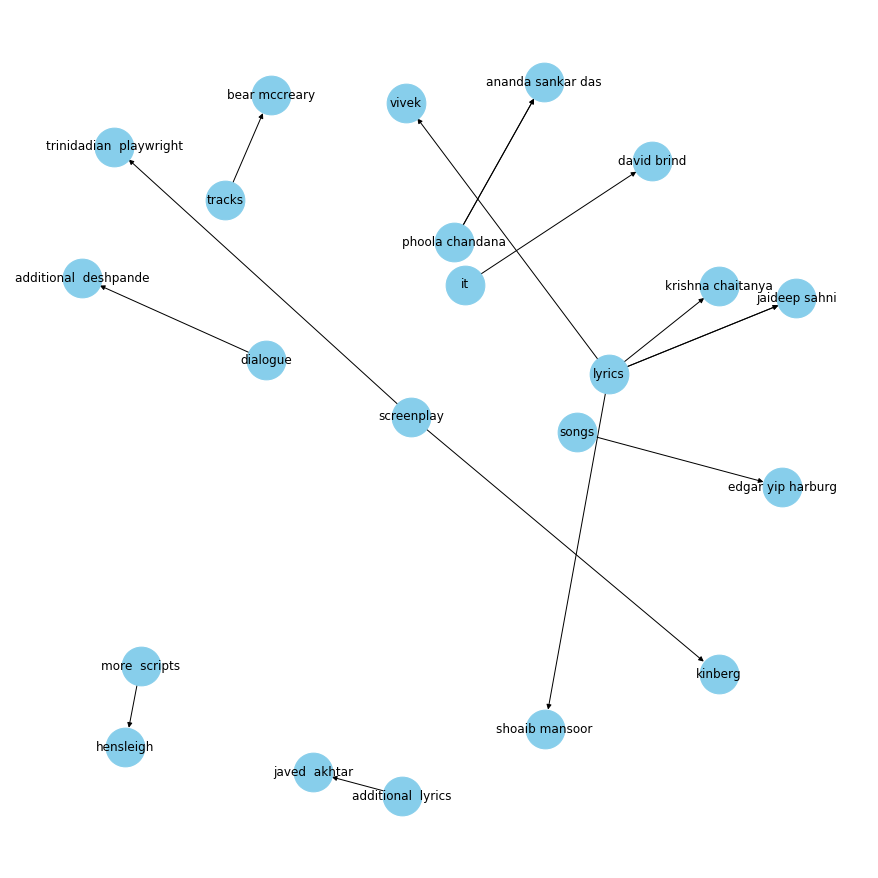

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

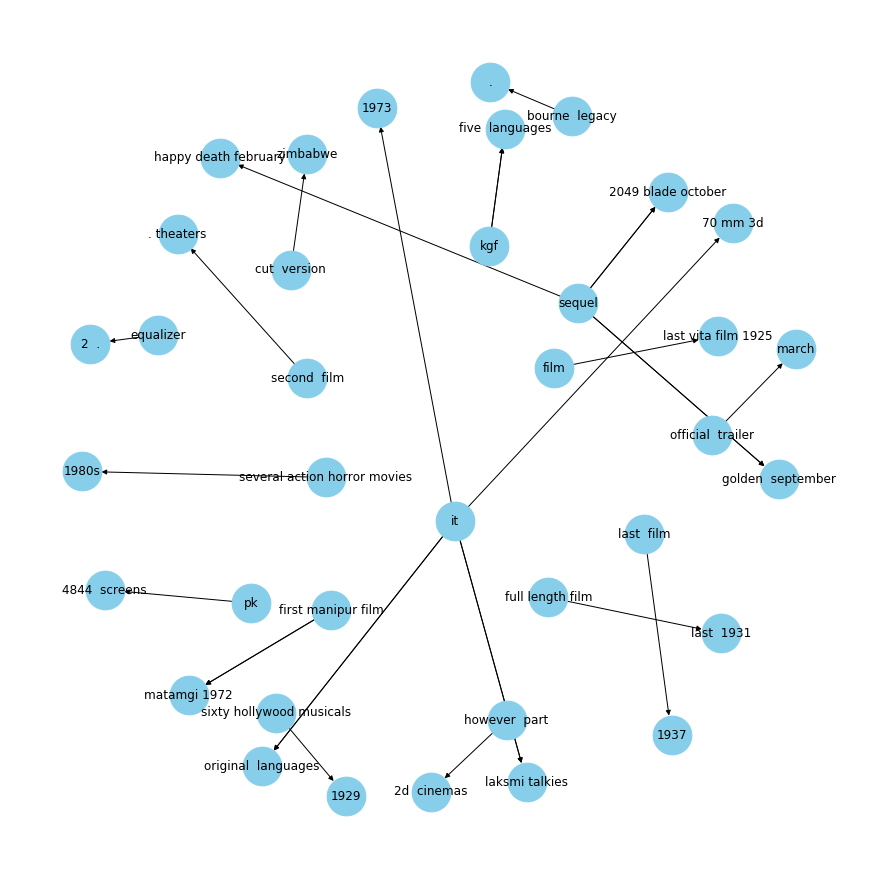

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()